<a href="https://colab.research.google.com/github/vkjadon/tf/blob/main/tf204-dogs-vs-cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import shutil
import glob

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import layers
from keras.models import Sequential

In [ ]:
!mkdir ~/.kaggle 

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:35<00:00, 24.7MB/s]
100% 812M/812M [00:35<00:00, 23.8MB/s]


In [ ]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip train.zip

In [ ]:
!ls

dogs-vs-cats.zip  sample_data		test1.zip  train.zip
kaggle.json	  sampleSubmission.csv	train


In [ ]:
filename=glob.glob('train/cat*')
print(len(filename))

12500


In [ ]:
if os.path.isdir('train/dog') is False:
  os.makedirs('train/dog')
  for c in random.sample(glob.glob('train/dog*'),1500):
    shutil.move(c,'train/dog')

In [ ]:
if os.path.isdir('train/cat') is False:
  os.makedirs('train/cat')
  for c in random.sample(glob.glob('train/cat*'),1500):
    shutil.move(c,'train/cat')

In [ ]:
filename=glob.glob('train/cat/*')
print("Cats in Train ",len(filename))
filename=glob.glob('train/dog/*')
print("Dogs in Train ",len(filename))

Cats in Train  1500
Dogs in Train  1500


Whenever we train a model, we need to put the data into a format that the model expects. A karass sequential model receives the data whenever we call the fit function. 
We create train, valid and test batches by using `ImageDataGenerator` and a directory iterator `flow_from_directory`. This basically creates batches of data from the directories we just created for training, validation and testing.

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
data_dir="train"

So let's focus just on train batches for now. So we're setting train batches equal to image data generator dot flow from directory.
But first to image data generator, we are specifying this pre processing function and setting that equal to tf Keras dot applications that VGG 16 dot pre process input.
This is a function that is going to apply some type of pre processing on the images before they get passed to the network that we'll be using. And we're processing them in such a way that is equivalent to the way that a very popular
model known as VGG 16, we're processing our images in the same format as which images that get passed to this VGG 16 model our process. And we're going to talk about more about this in a future episode.   

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


So besides that, when we call flow from directory, this is where we are passing in our actual data and specifying how we want this data to be processed. So we are setting directory equal to train path, which appear we defined the location on disk where our training set was under the train PATH variable. And then we're setting target size equal to 224 by 224.
So if you're working with an image data set that has images of varying sizes, or you just want to scale them up or scale them down, this is how you can specify that to happen. And this will resize all images in your data set to be of this height and width before passing them to our network. Now we are specifying our classes, which are just the classes for the potential labels of our data set. So cat or dog, and we are setting our batch size to 10.
We do the exact same thing for the validation set. And the test set.

Everything is the exact same for both of them, except for where each of these sets live on disk as being specified here under the directory parameter.
And then the only other difference is here for our test batches. We are specifying this shuffle equals false parameter.
Now, this is because whenever we use our test batches later for inference to get our model
to predict on images of cats and dogs after training and validation has been completed,
we're going to want to look at our prediction results in a confusion matrix like we did in a previous video for a separate data set.
And in order to do that, we need to be able to access the unsettled labels for our test
set. So that's why we set shuffle equals false for only this set. For both validation and training sets, we do want the data sets to be shuffled.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map` or you can include the layer inside your model definition, which can simplify deployment. We will use later method.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

In [ ]:
epochs=15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
75/75 [==============================] - 16s 50ms/step - loss: 0.8212 - accuracy: 0.5104 - val_loss: 0.6895 - val_accuracy: 0.5450
Epoch 2/15
75/75 [==============================] - 3s 35ms/step - loss: 0.6738 - accuracy: 0.5883 - val_loss: 0.6680 - val_accuracy: 0.6117
Epoch 3/15
75/75 [==============================] - 3s 36ms/step - loss: 0.6367 - accuracy: 0.6433 - val_loss: 0.6539 - val_accuracy: 0.6467
Epoch 4/15
75/75 [==============================] - 3s 36ms/step - loss: 0.5545 - accuracy: 0.7237 - val_loss: 0.6063 - val_accuracy: 0.6800
Epoch 5/15
75/75 [==============================] - 3s 36ms/step - loss: 0.5055 - accuracy: 0.7542 - val_loss: 0.6157 - val_accuracy: 0.6933
Epoch 6/15
75/75 [==============================] - 3s 36ms/step - loss: 0.3575 - accuracy: 0.8454 - val_loss: 0.6369 - val_accuracy: 0.6933
Epoch 7/15
75/75 [==============================] - 3s 36ms/step - loss: 0.2590 - accuracy: 0.8867 - val_loss: 0.7547 - val_accuracy: 0.6667
Epoch 8/15
7

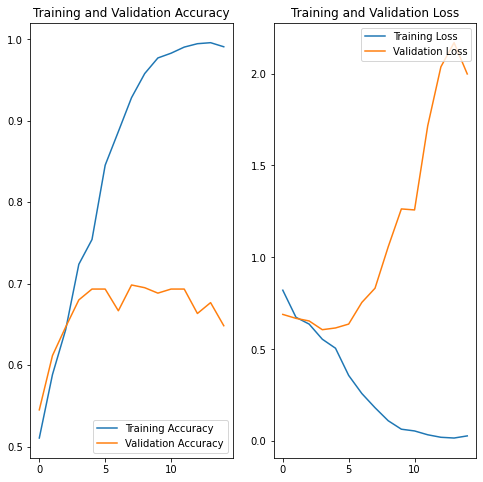

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

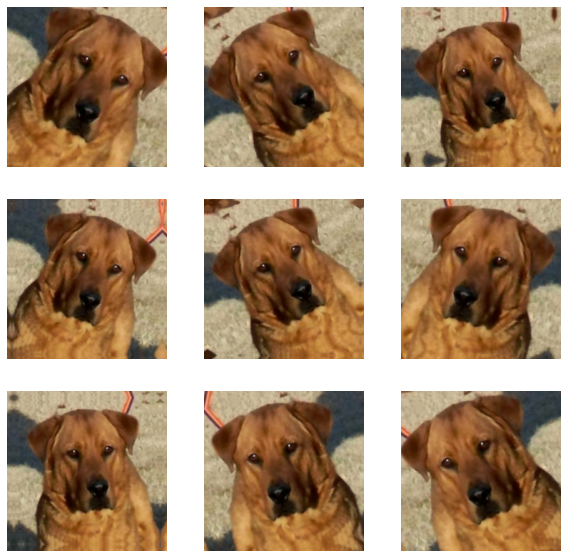

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
75/75 [==============================] - 7s 78ms/step - loss: 0.7044 - accuracy: 0.5233 - val_loss: 0.7031 - val_accuracy: 0.5100
Epoch 2/15
75/75 [==============================] - 6s 76ms/step - loss: 0.6700 - accuracy: 0.5992 - val_loss: 0.6527 - val_accuracy: 0.6050
Epoch 3/15
75/75 [==============================] - 6s 76ms/step - loss: 0.6439 - accuracy: 0.6346 - val_loss: 0.6384 - val_accuracy: 0.6417
Epoch 4/15
75/75 [==============================] - 6s 75ms/step - loss: 0.6367 - accuracy: 0.6488 - val_loss: 0.6526 - val_accuracy: 0.6267
Epoch 5/15
75/75 [==============================] - 6s 75ms/step - loss: 0.6115 - accuracy: 0.6667 - val_loss: 0.6270 - val_accuracy: 0.6583
Epoch 6/15
75/75 [==============================] - 6s 76ms/step - loss: 0.5846 - accuracy: 0.6850 - val_loss: 0.5995 - val_accuracy: 0.6750
Epoch 7/15
75/75 [==============================] - 6s 75ms/step - loss: 0.5672 - accuracy: 0.7158 - val_loss: 0.5929 - val_accuracy: 0.6833
Epoch 8/15
75

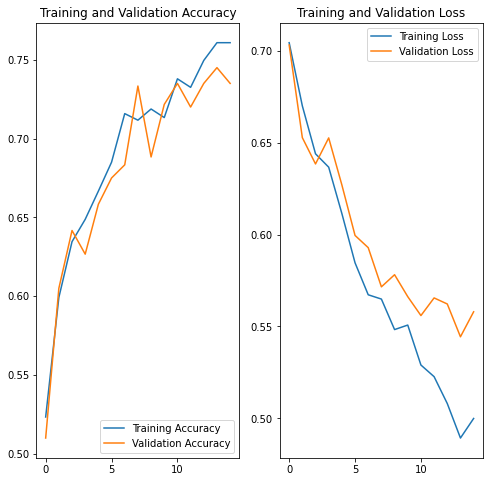

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
!pwd

/content


In [ ]:
!unzip test1.zip

In [ ]:
#image = tf.keras.utils.load_img(image_path)
#input_arr = tf.keras.utils.img_to_array(image)
#input_arr = np.array([input_arr])  # Convert single image to a batch.
#predictions = model.predict(input_arr)

img = tf.keras.utils.load_img("test1/1.jpg", target_size=(img_height, img_width),)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 153ms/step
This image most likely belongs to dog with a 89.69 percent confidence.
